## 1 - Introduction
The aim of this notebook is to me (and others) to understand the process of organizing and preparing the data, selecting the features, choosing and applying the machine learning tools, comparing, selecting and improving the best models.

The features from the data set describe characteristics of the cell nuclei and are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. As described in UCI Machine Learning Repository, the attribute informations are:

ID number
Diagnosis (M = malignant, B = benign)
3 - 32 Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter)<br>
b) texture (standard deviation of gray-scale values)<br>
c) perimeter<br>
d) area<br>
e) smoothness (local variation in radius lengths)<br>
f) compactness (perimeter^2 / area - 1.0)<br>
g) concavity (severity of concave portions of the contour)<br>
h) concave points (number of concave portions of the contour)<br>
i) symmetry<br>
j) fractal dimension ("coastline approximation" - 1)<br>
The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

## 2 - Preparing data

In [1]:
import sklearn
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from plotly.subplots import make_subplots
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
data = load_breast_cancer()

In [3]:
df = pd.DataFrame(data['data'],columns = data['feature_names'])
df['target'] = data['target']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
mean radius                569 non-null float64
mean texture               569 non-null float64
mean perimeter             569 non-null float64
mean area                  569 non-null float64
mean smoothness            569 non-null float64
mean compactness           569 non-null float64
mean concavity             569 non-null float64
mean concave points        569 non-null float64
mean symmetry              569 non-null float64
mean fractal dimension     569 non-null float64
radius error               569 non-null float64
texture error              569 non-null float64
perimeter error            569 non-null float64
area error                 569 non-null float64
smoothness error           569 non-null float64
compactness error          569 non-null float64
concavity error            569 non-null float64
concave points error       569 non-null float64
symmetry error             569 

## 3 - Data Visualization

There are 212 cases of malignant and 357 of benign.


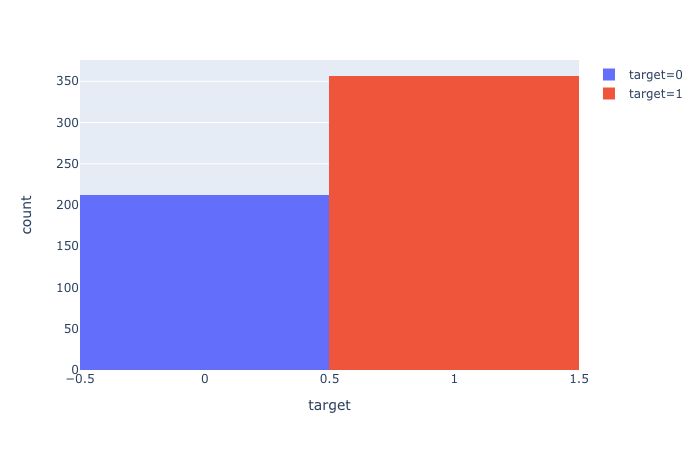

In [4]:
x = df['target'].value_counts().to_list()
print('There are {} cases of malignant and {} of benign.' .format(x[1],x[0]))
fig = px.histogram(df,x = 'target',color = 'target')
fig.show('png')

In the above plot it shows that most of the cases are malignant. So, if you build a classifier on this dataset that predicts all cases to be Benign, the classifier is right 62.1% of the time.

In [5]:
mean_features = data['feature_names'][:10]
worst_features = data['feature_names'][20:30]
error_features = data['feature_names'][10:20]

In [6]:
mean_features,worst_features

(array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
        'mean smoothness', 'mean compactness', 'mean concavity',
        'mean concave points', 'mean symmetry', 'mean fractal dimension'],
       dtype='<U23'),
 array(['worst radius', 'worst texture', 'worst perimeter', 'worst area',
        'worst smoothness', 'worst compactness', 'worst concavity',
        'worst concave points', 'worst symmetry',
        'worst fractal dimension'], dtype='<U23'))

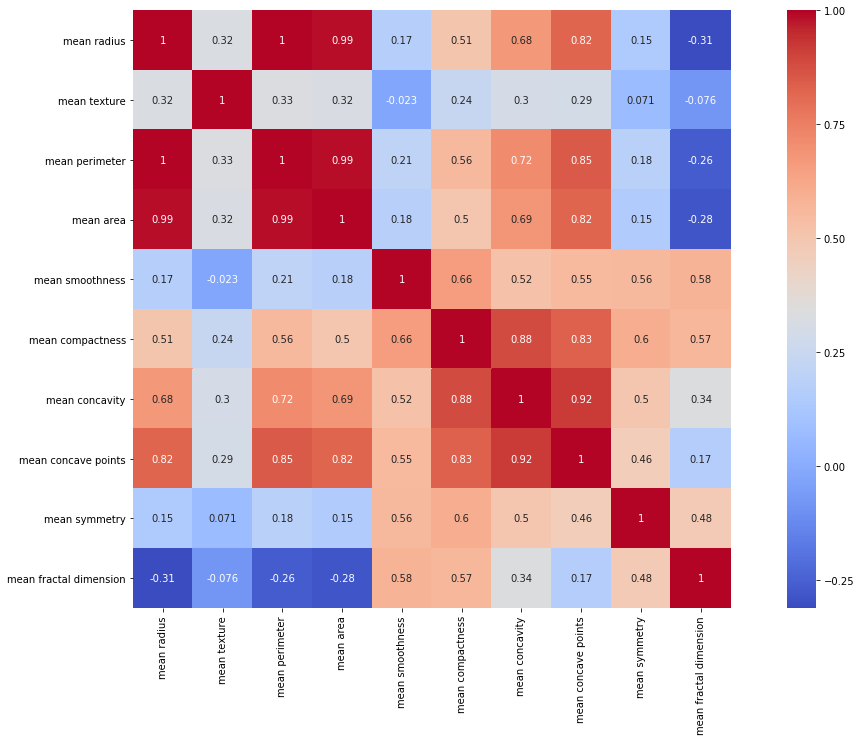

In [7]:
corr = df[mean_features].corr()
plt.figure(figsize = (20,11))
sns.heatmap(corr, annot = True, square = True, cmap = 'coolwarm')
plt.show()

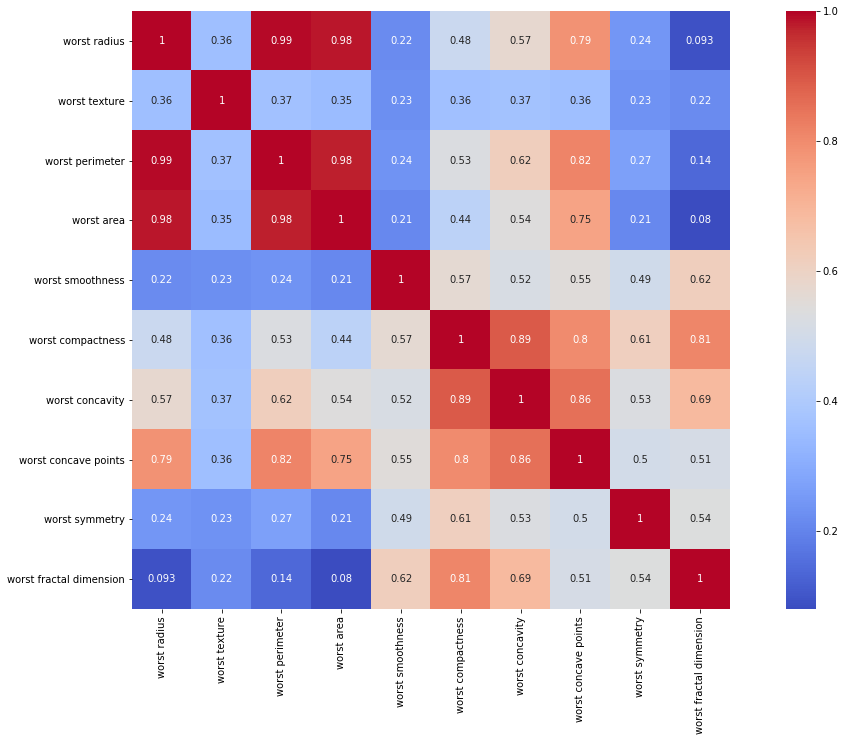

In [8]:
corr = df[worst_features].corr()
plt.figure(figsize = (20,11))
sns.heatmap(corr, annot = True, square = True, cmap = 'coolwarm')
plt.show()

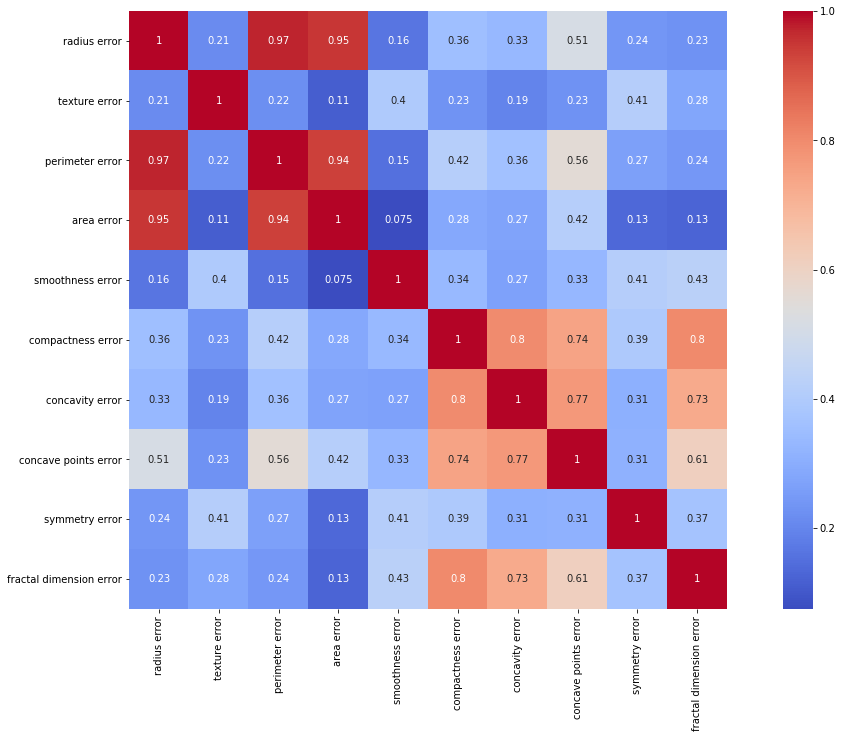

In [9]:
corr = df[error_features].corr()
plt.figure(figsize = (20,11))
sns.heatmap(corr, annot = True, square = True, cmap = 'coolwarm')
plt.show()

Highly correlated features:<br>
1. radius and area and perimeter.<br>
2. concave points and concavity<br>
4. concavity and compactness

In [10]:
features_to_remove = ['mean radius','mean perimeter','mean concavity','worst radius', 
                      'worst perimeter','worst concavity','radius error','perimeter error']
df.drop(features_to_remove,axis = 1,inplace = True)
mean_features = []
worst_features = []
error_features = []
for x in df.columns:
    if 'mean' in x:
        mean_features.append(x)
    if 'worst' in x:
        worst_features.append(x)
    if 'error' in x:
        error_features.append(x)
    

In [11]:
df.head()

,mean texture,mean area,mean smoothness,mean compactness,mean concave points,mean symmetry,mean fractal dimension,texture error,area error,smoothness error,...,symmetry error,fractal dimension error,worst texture,worst area,worst smoothness,worst compactness,worst concave points,worst symmetry,worst fractal dimension,target
0,10.38,1001.0,0.11840,0.27760,0.14710,0.2419,0.07871,0.9053,153.40,0.006399,...,0.03003,0.006193,17.33,2019.0,0.1622,0.6656,0.2654,0.4601,0.11890,0
1,17.77,1326.0,0.08474,0.07864,0.07017,0.1812,0.05667,0.7339,74.08,0.005225,...,0.01389,0.003532,23.41,1956.0,0.1238,0.1866,0.1860,0.2750,0.08902,0
2,21.25,1203.0,0.10960,0.15990,0.12790,0.2069,0.05999,0.7869,94.03,0.006150,...,0.02250,0.004571,25.53,1709.0,0.1444,0.4245,0.2430,0.3613,0.08758,0
3,20.38,386.1,0.14250,0.28390,0.10520,0.2597,0.09744,1.1560,27.23,0.009110,...,0.05963,0.009208,26.50,567.7,0.2098,0.8663,0.2575,0.6638,0.17300,0
4,14.34,1297.0,0.10030,0.13280,0.10430,0.1809,0.05883,0.7813,94.44,0.011490,...,0.01756,0.005115,16.67,1575.0,0.1374,0.2050,0.1625,0.2364,0.07678,0


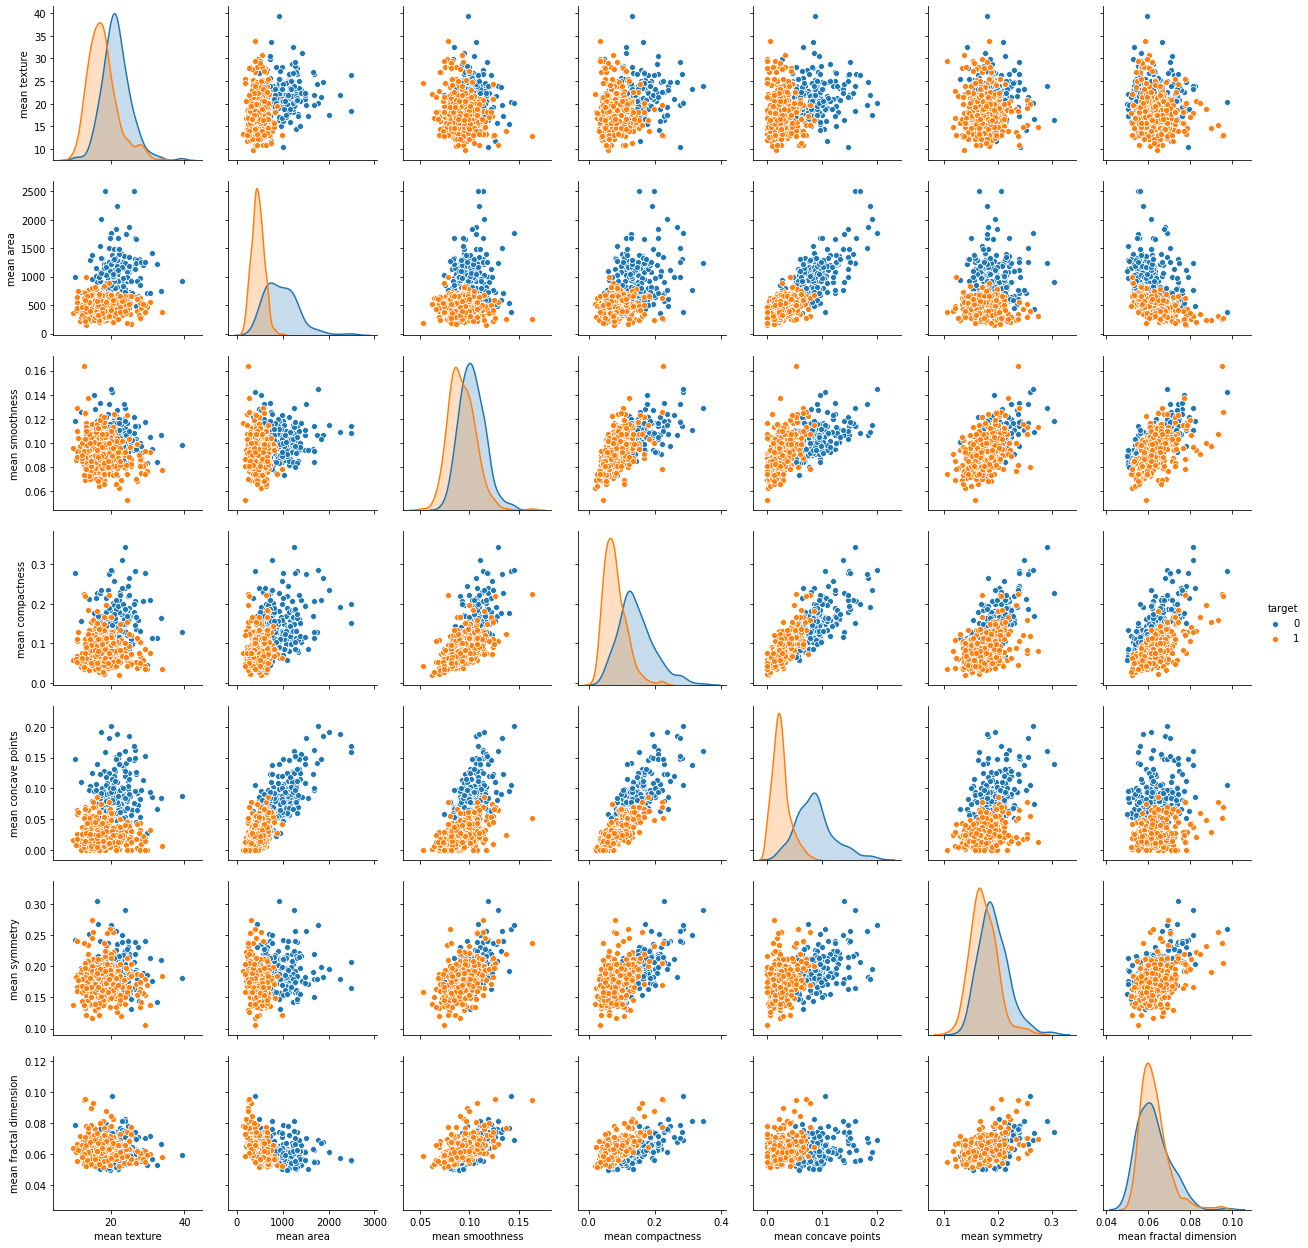

In [12]:
sns.pairplot(df,vars = mean_features, hue = 'target')

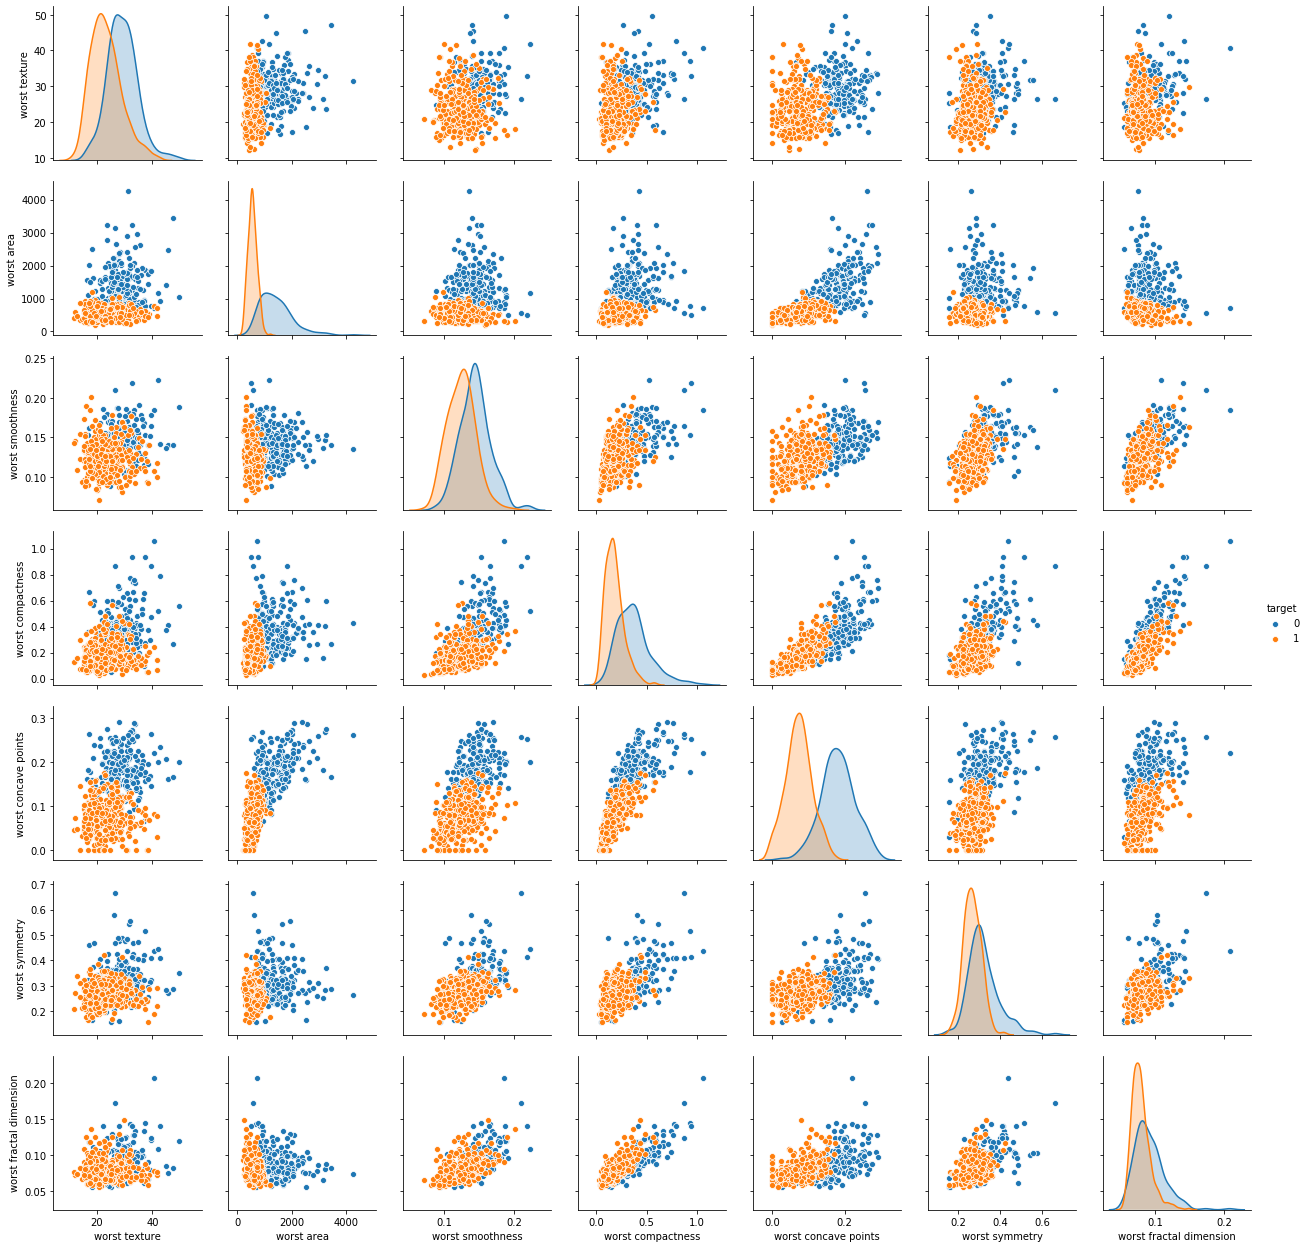

In [13]:
sns.pairplot(df,vars = worst_features, hue = 'target')

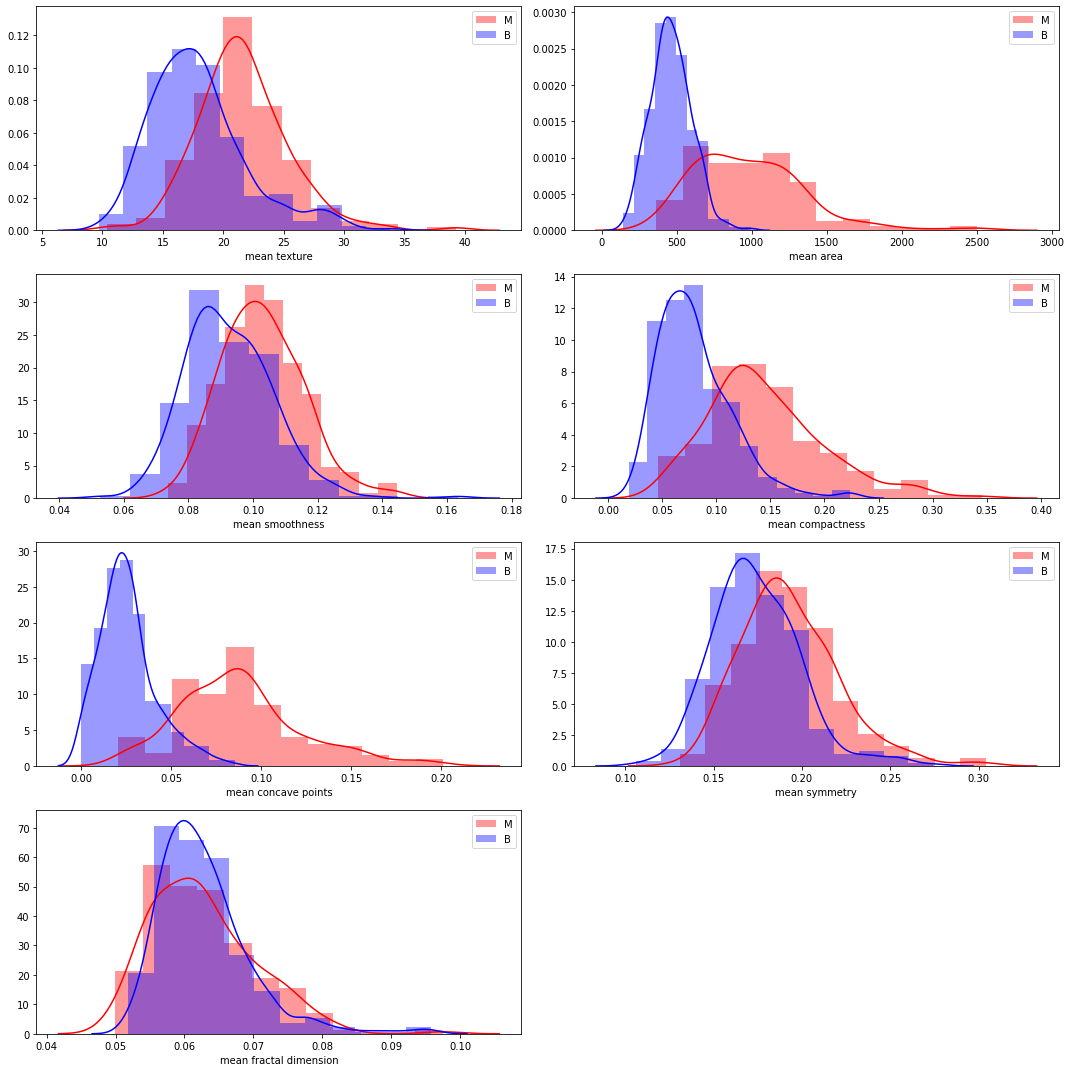

In [14]:
bins = 12
plt.figure(figsize=(15,15))
for i, feature in enumerate(mean_features):
    rows = int(len(mean_features)/2)+1
    plt.subplot(rows, 2, i+1)
    sns.distplot(df[df['target']==0][feature], bins=bins, color='red', label='M');
    sns.distplot(df[df['target']==1][feature], bins=bins, color='blue', label='B');   
    plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

The above plot shows the distribution of each mean features. Some features have values distributed in such a way that it can be determined whether the particular diagnosis is malignant or benign. We will extract those particular features.

In [15]:
mean_features_selected = ['mean area', 'mean concave points']

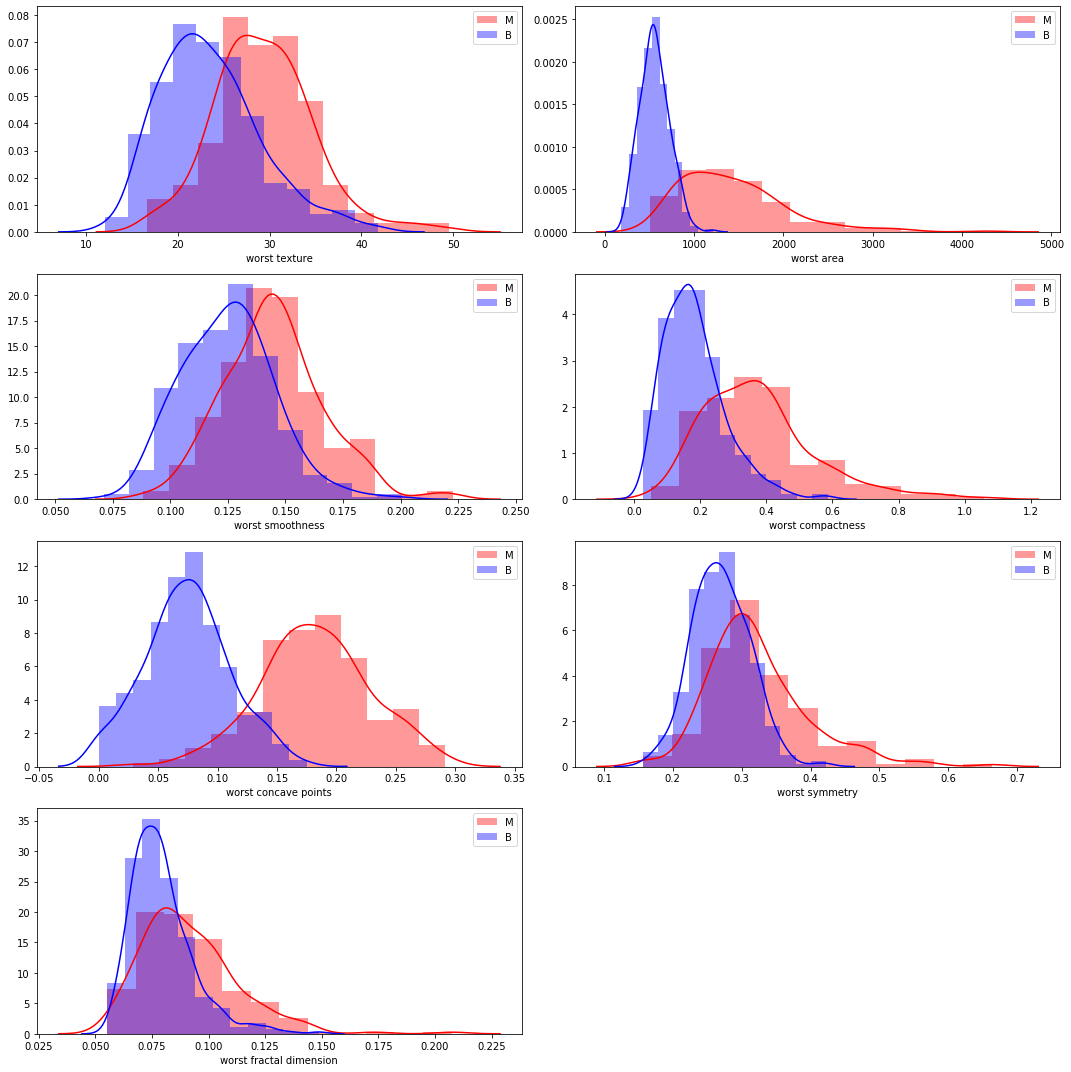

In [16]:
bins = 12
plt.figure(figsize=(15,15))
for i, feature in enumerate(worst_features):
    rows = int(len(mean_features)/2)+1
    plt.subplot(rows, 2, i+1)
    sns.distplot(df[df['target']==0][feature], bins=bins, color='red', label='M');
    sns.distplot(df[df['target']==1][feature], bins=bins, color='blue', label='B');   
    plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

The above plot shows the distribution of each worst features. The features which have values distributed in such a way that the diagnosis can be determined accurately are worst area, worst concave points.

In [17]:
worst_features_selected = ['worst area', 'worst concave points']

In [18]:
features_selected = mean_features_selected + worst_features_selected

In [19]:
features_selected

['mean area', 'mean concave points', 'worst area', 'worst concave points']

## 4 - Machine Learning

In [20]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
import time

The classifiers we will be using for predictions on the dataset are:

1. Stochastic Gradient Descent
2. Naive Bayes
3. Support Vector Machines (SVMs)
4. K- Nearest Neighbors (KNNs)
5. Random Forest Classifiers

## 4.1 -  Using all features

We will be using all the mean and worst features in this section. 

In [21]:
X = df.loc[:,mean_features+worst_features]
y = df.loc[:,'target']
scaler=StandardScaler()
X=scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print('Train size: {}'.format(X_train.shape[0]))
print('Test size: {}'.format(X_test.shape[0]))

Train size: 455
Test size: 114


In [22]:
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

accuracy_train1 = []
accuracy_test1 = []
cv_score1 = []
f1_score1 = []
precision1 = []
recall1 = []


for func in (SGDClassifier(),GaussianNB(),SVC(),NuSVC(),LinearSVC(),KNeighborsClassifier(),RandomForestClassifier()):
    start = time.time()
    clf = func
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    cvscore = cross_val_score(clf, X, y, cv=5)

    end = time.time()

    accuracy_train1.append(accuracy_score(y_train_pred, y_train))
    accuracy_test1.append(accuracy_score(y_test_pred, y_test))
    cv_score1.append(np.mean(cvscore))
    f1_score1.append(metrics.f1_score(y_train_pred,y_train))
    precision1.append(metrics.precision_score(y_test_pred,y_test))
    recall1.append(metrics.recall_score(y_test_pred,y_test))

    print(str(func).split('(')[0])
    print('Precision: {}, Recall : {}'
          .format(metrics.precision_score(y_test_pred,y_test),metrics.recall_score(y_test_pred,y_test)))
    print('Accuracy on training set: {:.2%}'
          .format(accuracy_score(y_train_pred, y_train)))
    print('Accuracy on test set: {:.2%}'
          .format(accuracy_score(y_test_pred, y_test)))
    print('Crossval score: {:.2%} (+/- {:.2%})'
          .format(np.mean(cvscore),np.std(cvscore)*2))
    print('Time taken : {:.5} seconds'
          .format(end - start))
    print('\n')

SGDClassifier
Precision: 0.9436619718309859, Recall : 0.9852941176470589
Accuracy on training set: 98.46%
Accuracy on test set: 95.61%
Crossval score: 96.31% (+/- 2.01%)
Time taken : 0.01563 seconds


GaussianNB
Precision: 0.971830985915493, Recall : 0.9452054794520548
Accuracy on training set: 92.97%
Accuracy on test set: 94.74%
Crossval score: 92.98% (+/- 3.76%)
Time taken : 0.010629 seconds


SVC
Precision: 0.971830985915493, Recall : 0.971830985915493
Accuracy on training set: 98.02%
Accuracy on test set: 96.49%
Crossval score: 96.13% (+/- 2.38%)
Time taken : 0.024328 seconds


NuSVC
Precision: 0.971830985915493, Recall : 0.9452054794520548
Accuracy on training set: 94.95%
Accuracy on test set: 94.74%
Crossval score: 94.56% (+/- 3.33%)
Time taken : 0.042301 seconds


LinearSVC
Precision: 0.9859154929577465, Recall : 0.958904109589041
Accuracy on training set: 98.02%
Accuracy on test set: 96.49%
Crossval score: 97.36% (+/- 1.95%)
Time taken : 0.027223 seconds


KNeighborsClassifier


### 4.1.2 Using selected features

In [23]:
X = df.loc[:,features_selected]
y = df.loc[:,'target']
scaler=StandardScaler()
X=scaler.fit_transform(X)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size = 0.2, random_state = 42)
print('Train size: {}'.format(X_train.shape[0]))
print('Test size: {}'.format(X_test.shape[0]))

Train size: 455
Test size: 114


In [24]:
accuracy_train2 = []
accuracy_test2 = []
cv_score2 = []
f1_score2 = []
precision2 = []
recall2 = []


for func in (SGDClassifier(),GaussianNB(),SVC(),NuSVC(),LinearSVC(),KNeighborsClassifier(),RandomForestClassifier()):
    start = time.time()
    clf = func
    clf.fit(X_train1, y_train1)
    y_train_pred = clf.predict(X_train1)
    y_test_pred = clf.predict(X_test1)
    cvscore = cross_val_score(clf, X, y, cv=5)

    end = time.time()

    accuracy_train2.append(accuracy_score(y_train_pred, y_train1))
    accuracy_test2.append(accuracy_score(y_test_pred, y_test1))
    cv_score2.append(np.mean(cvscore))
    f1_score2.append(metrics.f1_score(y_train_pred,y_train1))
    precision2.append(metrics.precision_score(y_test_pred,y_test1))
    recall2.append(metrics.recall_score(y_test_pred,y_test1))
    
    print(str(func).split('(')[0])
    print('Precision: {}, Recall : {}'
          .format(metrics.precision_score(y_test_pred,y_test1),metrics.recall_score(y_test_pred,y_test1)))
    print('Accuracy on training set: {:.2%}'
          .format(accuracy_score(y_train_pred, y_train1)))
    print('Accuracy on test set: {:.2%}'
          .format(accuracy_score(y_test_pred, y_test1)))
    print('Crossval score: {:.2%} (+/- {:.2%})'
          .format(np.mean(cvscore),np.std(cvscore)*2))
    print('Time taken : {:.5} seconds'
          .format(end - start))
    print('\n')

SGDClassifier
Precision: 1.0, Recall : 0.9466666666666667
Accuracy on training set: 95.82%
Accuracy on test set: 96.49%
Crossval score: 95.44% (+/- 5.53%)
Time taken : 0.015401 seconds


GaussianNB
Precision: 0.971830985915493, Recall : 0.9583333333333334
Accuracy on training set: 93.41%
Accuracy on test set: 95.61%
Crossval score: 94.21% (+/- 4.69%)
Time taken : 0.0099721 seconds


SVC
Precision: 0.971830985915493, Recall : 0.9583333333333334
Accuracy on training set: 94.51%
Accuracy on test set: 95.61%
Crossval score: 94.39% (+/- 5.07%)
Time taken : 0.016021 seconds


NuSVC
Precision: 0.971830985915493, Recall : 0.9452054794520548
Accuracy on training set: 93.41%
Accuracy on test set: 94.74%
Crossval score: 93.69% (+/- 6.12%)
Time taken : 0.033411 seconds


LinearSVC
Precision: 1.0, Recall : 0.9861111111111112
Accuracy on training set: 96.04%
Accuracy on test set: 99.12%
Crossval score: 96.14% (+/- 5.22%)
Time taken : 0.011761 seconds


KNeighborsClassifier
Precision: 0.9718309859154

For detecting the breast cancer the precision can be low, since false positives can be entertained. But the recall must be high since the False Negatives might impact the patient's decision. Therefore, minimizing the risk of the patients with malignant tumor being told that it's benign.

In [25]:
index = ['SGDClassifier','GaussianNB','SVC','NuSVC','LinearSVC','KNeighborsClassifier','RandomForestClassifier']
d = {'accuracy_train_all': accuracy_train1, 'accuracy_train_sel': accuracy_train2,
     'accuracy_test_all':accuracy_test1,
     'accuracy_test_sel':accuracy_test2,
     'cv_score_all': cv_score1,'cv_score_sel':cv_score2,'pr_score_all' : precision1,'pr_score_sel':precision2,
    'r_score_all' : recall1,'r_score_sel':recall2}
measures = pd.DataFrame(d,index=index)
measures

,accuracy_train_all,accuracy_train_sel,accuracy_test_all,accuracy_test_sel,cv_score_all,cv_score_sel,pr_score_all,pr_score_sel,r_score_all,r_score_sel
SGDClassifier,0.984615,0.958242,0.956140,0.964912,0.963140,0.954382,0.943662,1.000000,0.985294,0.946667
GaussianNB,0.929670,0.934066,0.947368,0.956140,0.929819,0.942147,0.971831,0.971831,0.945205,0.958333
SVC,0.980220,0.945055,0.964912,0.956140,0.961339,0.943917,0.971831,0.971831,0.971831,0.958333
NuSVC,0.949451,0.934066,0.947368,0.947368,0.945594,0.936899,0.971831,0.971831,0.945205,0.945205
LinearSVC,0.980220,0.960440,0.964912,0.991228,0.973605,0.961431,0.985915,1.000000,0.958904,0.986111
KNeighborsClassifier,0.960440,0.953846,0.956140,0.956140,0.954290,0.943917,0.971831,0.971831,0.958333,0.958333
RandomForestClassifier,1.000000,0.997802,0.956140,0.947368,0.959754,0.940377,0.985915,0.971831,0.945946,0.945205


The cross validation scores of Random Forest Classifier are the highest. <br>
The Linear SVC has the least accuracy and cross validation scores. <br>
The GuassianNB classifier looks like the best classifier with the best Cross Validation scores and the model is not overfitting, and the recall scores are the highest, which is essential for this particular problem (reducing false negatives). <br>
Overall, most of the classifiers seem to perform well when all for the features are used of learning.

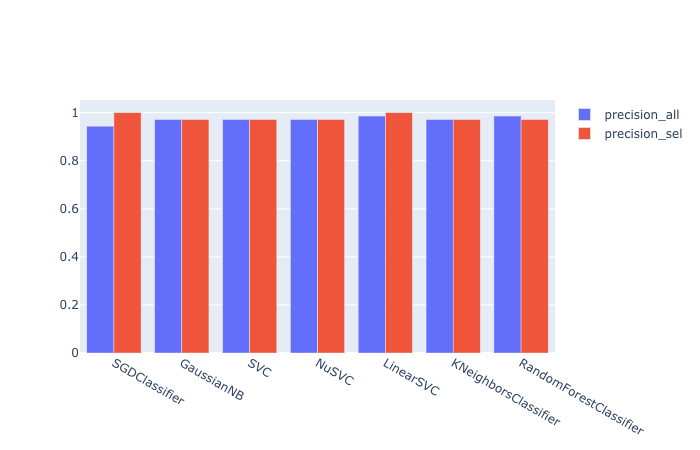

In [26]:
fig = go.Figure()
fig.add_trace(go.Bar(x = measures.reset_index()['index'],
                     y = measures.reset_index()['pr_score_all'],
                     name = 'precision_all'))
fig.add_trace(go.Bar(x = measures.reset_index()['index'],
                     y = measures.reset_index()['pr_score_sel'],
                     name = 'precision_sel'))
fig.show('png')

The precision scores are better for selected features.

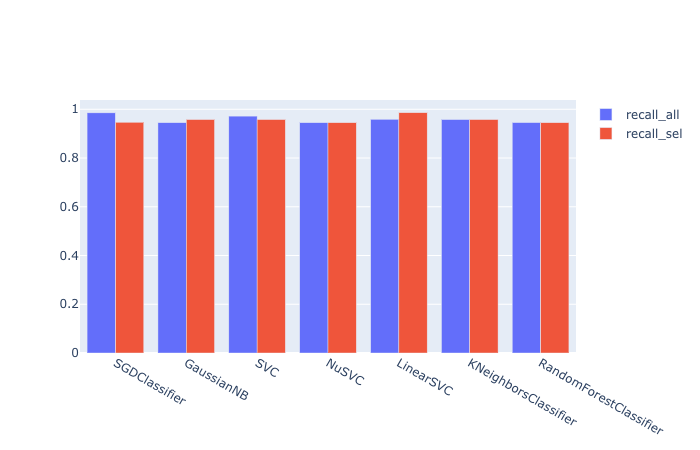

In [27]:
fig = go.Figure()
fig.add_trace(go.Bar(x = measures.reset_index()['index'],
                     y = measures.reset_index()['r_score_all'],
                     name = 'recall_all'))
fig.add_trace(go.Bar(x = measures.reset_index()['index'],
                     y = measures.reset_index()['r_score_sel'],
                     name = 'recall_sel'))
fig.show('png')

The recall scores are better when all the features are selected, and GuassianNB has the highest recall scores.

### Using 1-layer neural network

In [28]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

X, y = load_breast_cancer(return_X_y=True)
scaler=StandardScaler()
X=scaler.fit_transform(X)
x_train=X[:450]
y_train=y.reshape(y.shape[0],1)[:450]
x_test=X[450:]
y_test=y.reshape(y.shape[0],1)[450:]

model = Sequential()
model.add(Dense(8, input_dim=30, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, batch_size=10, validation_data=(x_test, y_test))

Using TensorFlow backend.


Train on 450 samples, validate on 119 samples
Epoch 1/10
450/450 [==============================] - 0s 425us/step - loss: 0.6546 - accuracy: 0.5867 - val_loss: 0.4955 - val_accuracy: 0.7899
Epoch 2/10
450/450 [==============================] - 0s 118us/step - loss: 0.5654 - accuracy: 0.6400 - val_loss: 0.4379 - val_accuracy: 0.8403
Epoch 3/10
450/450 [==============================] - 0s 118us/step - loss: 0.5010 - accuracy: 0.7289 - val_loss: 0.3943 - val_accuracy: 0.9160
Epoch 4/10
450/450 [==============================] - 0s 117us/step - loss: 0.4500 - accuracy: 0.8422 - val_loss: 0.3567 - val_accuracy: 0.9664
Epoch 5/10
450/450 [==============================] - 0s 111us/step - loss: 0.4043 - accuracy: 0.8844 - val_loss: 0.3204 - val_accuracy: 0.9664
Epoch 6/10
450/450 [==============================] - 0s 112us/step - loss: 0.3651 - accuracy: 0.9067 - val_loss: 0.2915 - val_accuracy: 0.9664
Epoch 7/10
450/450 [==============================] - 0s 120us/step - loss: 0.3312 - accur

Training a neural network gave more accuracy!